In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


train_path = 'kaggle_housing_data/train.csv'
test_path = 'kaggle_housing_data/test.csv'

df_test = pd.read_csv(test_path)
df_train = pd.read_csv(train_path)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [75]:
from src import utils
try:
    df_train.drop("Id", axis=1, inplace=True)
    df_test.drop("Id", axis=1, inplace=True)
except:
    print("Id columns already removed.")

missing_pct_cols = utils.drop_null_majority_features(df_train, df_test)
housing = df_train.copy()

Analyzing single-value dominant features:
  DROPPING Street: 99.6% are 'Pave'
  DROPPING Utilities: 99.9% are 'AllPub'
  DROPPING Condition2: 99.0% are 'Norm'
  DROPPING RoofMatl: 98.2% are 'CompShg'
  DROPPING Heating: 97.8% are 'GasA'


In [76]:
housing["1stFlrRatio"] = housing["1stFlrSF"] / housing["GrLivArea"]
housing["yrsSinceRemod"] = housing["YrSold"] - housing["YearRemodAdd"]
housing["bdrmRatio"] = housing["BedroomAbvGr"] / housing["TotRmsAbvGrd"]

scaled_liv_area = (housing['GrLivArea'] / housing['GrLivArea'].max()) * 10
housing["OvaAll"] = housing['OverallCond'] + housing['OverallQual'] + scaled_liv_area

housing["BathAbvGr"] = housing['FullBath'] + housing['HalfBath']
housing['RmsWBathRms'] = housing['TotRmsAbvGrd'] + housing['BathAbvGr']
housing['BathToRoomRatio'] = housing["BathAbvGr"] / (housing['RmsWBathRms'])

In [77]:
corr_matrix = housing.corr(numeric_only=True)

print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice          1.000000
OverallQual        0.790982
OvaAll             0.738429
GrLivArea          0.708624
GarageCars         0.640409
GarageArea         0.623431
TotalBsmtSF        0.613581
1stFlrSF           0.605852
RmsWBathRms        0.600357
BathAbvGr          0.568267
FullBath           0.560664
TotRmsAbvGrd       0.533723
YearBuilt          0.522897
YearRemodAdd       0.507101
GarageYrBlt        0.486362
MasVnrArea         0.477493
Fireplaces         0.466929
BsmtFinSF1         0.386420
LotFrontage        0.351799
WoodDeckSF         0.324413
2ndFlrSF           0.319334
OpenPorchSF        0.315856
BathToRoomRatio    0.307893
HalfBath           0.284108
LotArea            0.263843
BsmtFullBath       0.227122
BsmtUnfSF          0.214479
BedroomAbvGr       0.168213
ScreenPorch        0.111447
PoolArea           0.092404
MoSold             0.046432
3SsnPorch          0.044584
BsmtFinSF2        -0.011378
BsmtHalfBath      -0.016844
MiscVal           -0.021190
LowQualFinSF      -0

In [78]:
housing['OvaAll'] = np.log(housing['OvaAll']) 

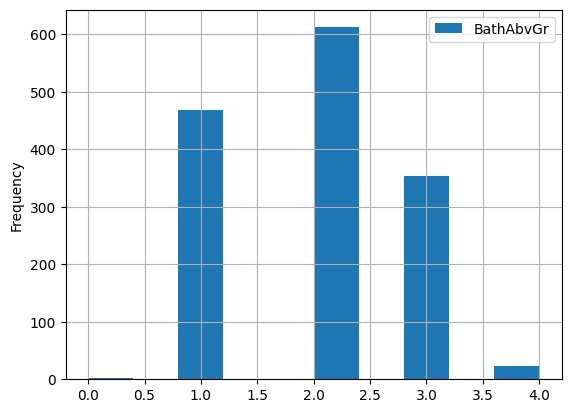

In [79]:
housing.plot(kind="hist", y="BathAbvGr", grid=True)
plt.show()